This Notebook aims to combine all necessary steps for each model of the nonlinear ML methods.

In [1]:
# first import the libraries
import pandas as pd
import numpy as np
from darts import TimeSeries
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from darts.models import LinearRegressionModel, RegressionModel, RandomForest, RegressionEnsembleModel
from sklearn import cross_decomposition
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from darts.metrics import mape, r2_score, mase, mse
import sklearn
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns


import warnings

In [2]:
# Filter out the FutureWarning message
warnings.filterwarnings("ignore", category=(FutureWarning))
warnings.filterwarnings("ignore", category=(UserWarning))
# get rid of the LinAlgWarning message
#from numpy.linalg import LinAlgWarning
#warnings.filterwarnings('ignore', category=LinAlgWarning)

In [3]:
# load the data, use Darts TimeSeries
ts = TimeSeries.from_csv('data/price_data_filtered.csv', parse_dates=True, index_col=0)

In [4]:
# compute monthly returns using pandas pct_change
returns = ts.pd_dataframe().pct_change().dropna()

Stored 'cum_returns' (DataFrame)


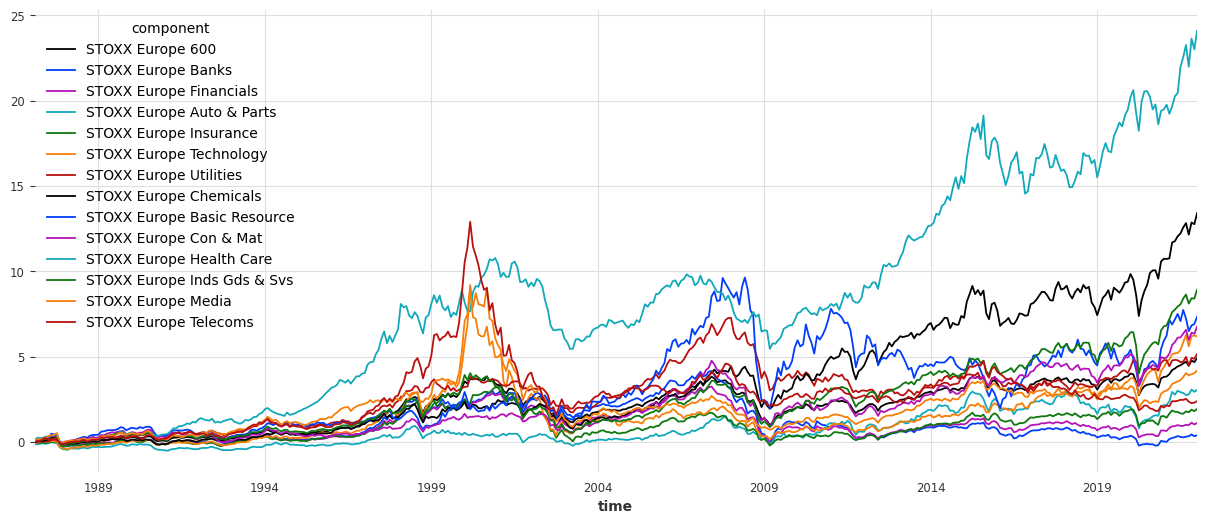

In [5]:
#from io import BytesIO
# compute the cumulative monthly returns
cum_returns = (1 + returns).cumprod() - 1

cum_returns_portfolio = cum_returns
# store the cum_returns to use it in another notebook
%store cum_returns

# plot the cumulative returns
fig, ax = plt.subplots(figsize=(15, 6))
cum_returns.plot(ax=ax);

In [6]:
# to use the Darts models, we need to convert the data to a Darts TimeSeries
cum_returns = TimeSeries.from_dataframe(df = cum_returns,time_col= 0, fill_missing_dates=True)

In [7]:
# split the data into training and test set, use 80% for training
train, test = cum_returns.split_after(0.8)

## Benchmark Portfolios

Our main benchmark is the STOXX Europe 600 Index. Furthermore, we expand the benchmarks by computing the equal weighted portfolio and portfolio based on historical averages.

### Equal Weighted Portfolio

In [8]:
# create a list of the column names
col_list = list(cum_returns.columns)[1:]

# create weights
weights_ew = 1/len(col_list)

# print single weight and the sum of all weights
print('The weight for each stock is: ' + str(weights_ew))
print('The sum of all weights is: ' + str(weights_ew * 13))

# create a new column in cum_returns for the equal weighted portfolio
cum_returns_portfolio['equal_weighted'] = cum_returns_portfolio[col_list].mul(weights_ew).sum(axis=1)

# create a new variable called portfolio_returns with same structure as cum_returns
portfolio_returns = cum_returns_portfolio.copy()
# delete all columns except for the equal_weighted column
portfolio_returns.drop(cum_returns_portfolio.columns.difference(['equal_weighted']), 1, inplace=True)
portfolio_returns.tail()

# delete equal weighted column from cum_returns
cum_returns_portfolio.drop('equal_weighted', axis=1, inplace=True)

The weight for each stock is: 0.07692307692307693
The sum of all weights is: 1.0


### Portfolio based on Historical Average

In [9]:
# Calculate average daily returns for each stock and exlude the first column
avg_returns = cum_returns_portfolio.mean()[1:]

# Calculate weights based on average daily returns
weights_ha = avg_returns / avg_returns.sum()

# Calculate portfolio returns
ha_returns = (cum_returns_portfolio * weights_ha).sum(axis=1)

# Add portfolio_returns as a new column in cum_returns
portfolio_returns['historical_average'] = ha_returns

# show the last 5 rows of portfolio_returns of historical average portfolio
portfolio_returns.tail()

component,equal_weighted,historical_average
time,,
2021-09-01,6.334322,10.565259
2021-10-01,5.926514,9.912039
2021-11-01,6.322933,10.583310
2021-12-01,6.237121,10.402550
2022-01-01,6.544394,10.913366


In [10]:
# print single weight and the sum of all weights for historical average portfolio
print('The weight for each stock is: ' + str(weights_ha))
print('The sum of all weights is: ' + str(weights_ha.sum()))

The weight for each stock is: component
STOXX Europe Banks             0.033024
STOXX Europe Financials        0.030685
STOXX Europe Auto & Parts      0.021829
STOXX Europe Insurance         0.027747
STOXX Europe Technology        0.050778
STOXX Europe Utilities         0.085845
STOXX Europe Chemicals         0.108597
STOXX Europe Basic Resource    0.099537
STOXX Europe Con & Mat         0.061754
STOXX Europe Health Care       0.258600
STOXX Europe Inds Gds & Svs    0.076979
STOXX Europe Media             0.063096
STOXX Europe Telecoms          0.081530
dtype: float64
The sum of all weights is: 1.0


## Nonlinear ML Methods

### Random Forest

In [90]:
hyperparameter_randomforest = {
    "lags": [1],
    'n_estimators': list(range(1, 101, 2)),
    'max_depth': list(range(1, 501, 2)),
    'random_state': [0]
}

In [165]:
random_forest_tune = RandomForest(
    lags=hyperparameter_randomforest['lags'][0], 
   n_estimators=hyperparameter_randomforest['n_estimators'][0],
    max_depth=hyperparameter_randomforest['max_depth'][0],
    random_state = 0
    )

In [166]:
tuning_randomforest = random_forest_tune.gridsearch(
    parameters= hyperparameter_randomforest,
    series= train,
    val_series= test,
    start= 0.1,
    #metric= mse,
    n_jobs= -1,
    verbose= True
)

  0%|          | 0/12500 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [93]:
# print the best model parameters
best_model, best_params = tuning_randomforest[0], tuning_randomforest[1]
best_model.model_params

OrderedDict([('lags', 1),
             ('lags_past_covariates', None),
             ('lags_future_covariates', None),
             ('output_chunk_length', 1),
             ('add_encoders', None),
             ('n_estimators', 1),
             ('max_depth', 25),
             ('multi_models', True),
             ('use_static_covariates', True)])

In [155]:
# random forest regression model with 1 lag
randomforest_model_1 = RegressionModel(lags=1, model=sklearn.ensemble.RandomForestRegressor(n_estimators=500, max_depth=500, random_state=0))
randomforest_model_1.fit(train)
randomforest_forecast_1 = randomforest_model_1.predict(len(test))

# random forest regression model with 316 lags
#randomforest_model_316 = RegressionModel(lags=316, model=sklearn.ensemble.RandomForestRegressor(n_estimators=100, max_depth=10000))
#randomforest_model_316.fit(train)
#randomforest_forecast_316 = randomforest_model_316.predict(len(test))

# random forest regression model with 317 lags
#randomforest_model_317 = RegressionModel(lags=317, model=sklearn.ensemble.RandomForestRegressor(n_estimators=100, max_depth=10))
#randomforest_model_317.fit(train)
#randomforest_forecast_317 = randomforest_model_317.predict(len(test))

# random forest regression model with 335 lags
#randomforest_model_335 = RegressionModel(lags=335, model=sklearn.ensemble.RandomForestRegressor(n_estimators=100, max_depth=1))
#randomforest_model_335.fit(train)
#randomforest_forecast_335 = randomforest_model_335.predict(len(test))

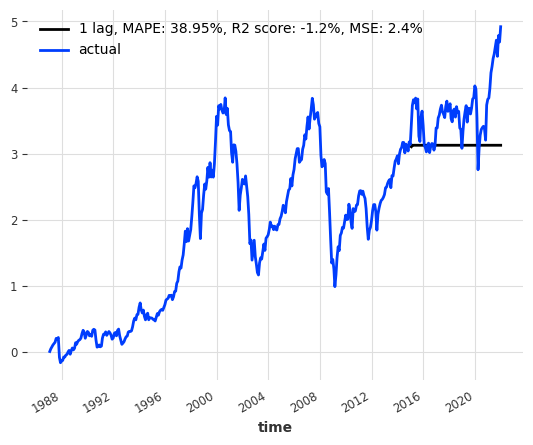

In [156]:
# plot the random forest forecast with 1, 316, 317 and 335 lags and label with MAPE rounded to 2 decimals and R2 score rounded to 2 decimals and MSE rounded to 2 decimals
randomforest_forecast_1['STOXX Europe 600'].plot(label='1 lag, MAPE: ' + str(round(mape(test, randomforest_forecast_1), 2)) + '%, R2 score: ' + str(round(r2_score(test, randomforest_forecast_1), 2)) + '%, MSE: ' + str(round(mse(test, randomforest_forecast_1), 2)) + '%')
#randomforest_forecast_316['STOXX Europe 600'].plot(label='316 lags, MAPE: ' + str(round(mape(test, randomforest_forecast_316), 2)) + '%, R2 score: ' + str(round(r2_score(test, randomforest_forecast_316), 2)) + '%, MSE: ' + str(round(mse(test, randomforest_forecast_316), 2)) + '%')
#randomforest_forecast_317['STOXX Europe 600'].plot(label='317 lags, MAPE: ' + str(round(mape(test, randomforest_forecast_317), 2)) + '%, R2 score: ' + str(round(r2_score(test, randomforest_forecast_317), 2)) + '%, MSE: ' + str(round(mse(test, randomforest_forecast_317), 2)) + '%')
#randomforest_forecast_335['STOXX Europe 600'].plot(label='335 lags, MAPE: ' + str(round(mape(test, randomforest_forecast_335), 2)) + '%, R2 score: ' + str(round(r2_score(test, randomforest_forecast_335), 2)) + '%, MSE: ' + str(round(mse(test, randomforest_forecast_335), 2)) + '%')

# rewrite to see only one line
cum_returns['STOXX Europe 600'].plot(label='actual')

In [157]:
# first random forest model with 1 lag
hf1_random_forest = randomforest_model_1.historical_forecasts(series= cum_returns, start= 0.7, forecast_horizon= 1, verbose= True)

# second random forest model with 316 lags
#hf2_random_forest = randomforest_model_316.historical_forecasts(series= cum_returns, start= 0.7, forecast_horizon= 1, verbose= True)

# third random forest model with 317 lags
#hf3_random_forest = randomforest_model_317.historical_forecasts(series= cum_returns, start= 0.7, forecast_horizon= 1, verbose= True)

# fourth random forest model with 335 lags
#hf4_random_forest = randomforest_model_335.historical_forecasts(series= cum_returns, start= 0.7, forecast_horizon= 1, verbose= True)

  0%|          | 0/127 [00:00<?, ?it/s]

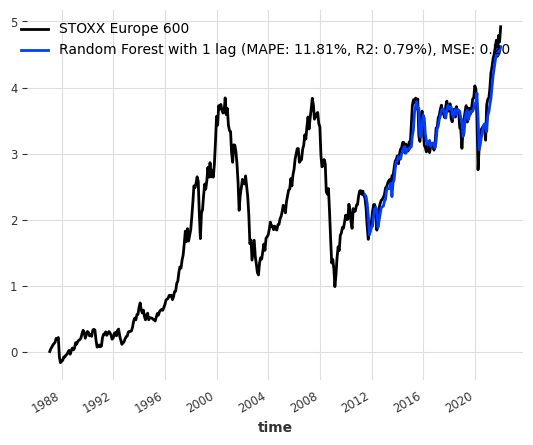

In [158]:
# compute historical forecasts that would have been obtained by this model
cum_returns['STOXX Europe 600'].plot(label='STOXX Europe 600')
hf1_random_forest['STOXX Europe 600'].plot(label='Random Forest with 1 lag (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf1_random_forest, cum_returns), r2_score(hf1_random_forest, cum_returns), mse(hf1_random_forest, cum_returns)))
#hf2_random_forest['STOXX Europe 600'].plot(label='Random Forest with 316 lags (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf2_random_forest, cum_returns), r2_score(hf2_random_forest, cum_returns), mse(hf2_random_forest, cum_returns)))
#hf3_random_forest['STOXX Europe 600'].plot(label='Random Forest with 317 lags (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf3_random_forest, cum_returns), r2_score(hf3_random_forest, cum_returns), mse(hf3_random_forest, cum_returns)))
#hf4_random_forest['STOXX Europe 600'].plot(label='Random Forest with 335 lags (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf4_random_forest, cum_returns), r2_score(hf4_random_forest, cum_returns), mse(hf4_random_forest, cum_returns)))

In [159]:
# change the type of the random forest forecast to a dataframe
randomforest_forecast_1 = randomforest_forecast_1.pd_dataframe()

In [160]:
# perform mean-variance optimization on the random forest forecast
mu_randomforest_1 = expected_returns.mean_historical_return(randomforest_forecast_1)
S_randomforest_1 = risk_models.sample_cov(randomforest_forecast_1)

In [161]:
# optimize for maximal Sharpe ratio
ef_randomforest_1 = EfficientFrontier(mu_randomforest_1, S_randomforest_1)
weights_randomforest_1 = ef_randomforest_1.max_sharpe()

In [162]:
# compute the returns of the random forest portfolio
rf_returns_1 = (cum_returns_portfolio * weights_randomforest_1).sum(axis=1)

portfolio_returns['random_forest_1'] = rf_returns_1

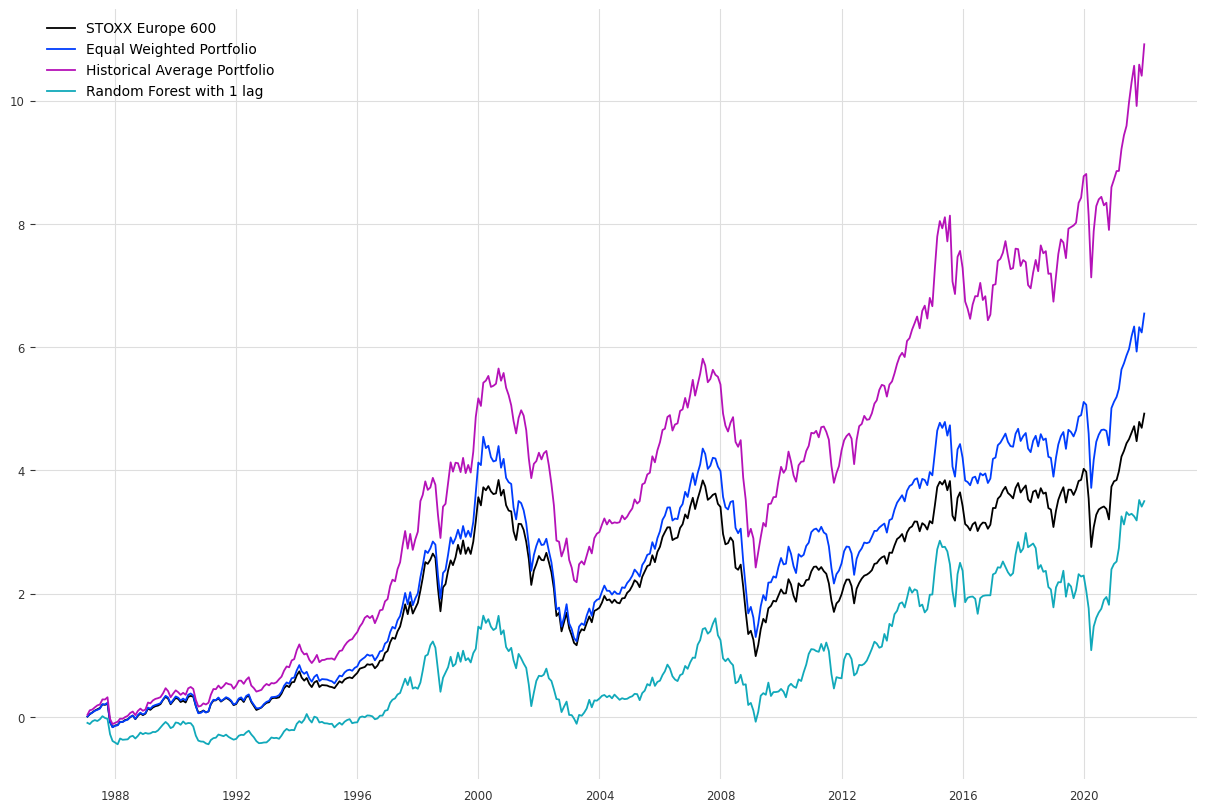

In [163]:
# plot the cumulative returns of the benchmark and the bridge regression portfolio
plt.figure(figsize=(15,10))
plt.plot(cum_returns_portfolio['STOXX Europe 600'], label='STOXX Europe 600')
plt.plot(portfolio_returns['equal_weighted'], label='Equal Weighted Portfolio')
plt.plot(portfolio_returns['historical_average'], label='Historical Average Portfolio')
plt.plot(portfolio_returns['random_forest_1'], label='Random Forest with 1 lag')
plt.legend(loc='upper left')
plt.show();

In [164]:
# show the last value of each portfolio and round it to 2 decimals
print('Last value of the STOXX Europe 600: ' + str(np.round(cum_returns_portfolio['STOXX Europe 600'].iloc[-1], 2)) + '%')
print('The last value of the equal weighted portfolio is: ' + str(round(portfolio_returns['equal_weighted'].iloc[-1], 2)) + '%')
print('The last value of the historical average portfolio is: ' + str(round(portfolio_returns['historical_average'].iloc[-1], 2)) + '%')
print('The last value of the random forest portfolio with 1 lag is: ' + str(round(portfolio_returns['random_forest_1'].iloc[-1], 2)) + '%')

Last value of the STOXX Europe 600: 4.92%
The last value of the equal weighted portfolio is: 6.54%
The last value of the historical average portfolio is: 10.91%
The last value of the random forest portfolio with 1 lag is: 3.5%
